# OLG Model with Individual Uncertainty

In [1]:
using Plots; gr()
using Rmath

# Setting up model parameters:

_eta       = 1.5
_beta      = 1.011
_alpha     = 0.36
_delta     = 0.06
_zeta      = 0.3
_gamma     = 2.0
_psi       = 0.001

_hbar      = 0.3

T          = 40  # maximum is 40
Tr         = 20  # maximum is 35

_rho       = 0.96
_sigma     = 0.045
_sigmay1   = 0.38

;

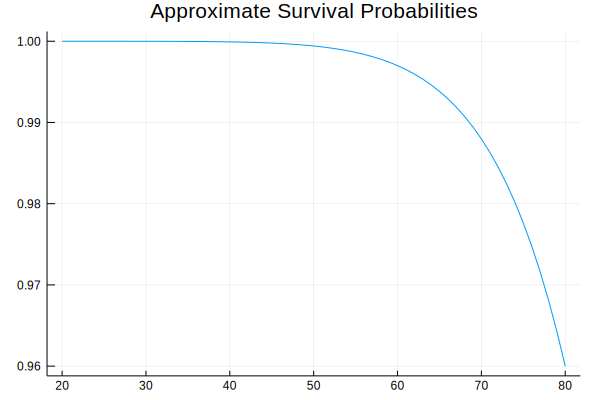

In [2]:
# Load survival probabilities [United Nations, 2002] and 
# age-productivity profile [Hansen, 1993] (normalised):

_Sprob = [ 1-(0.04)*(j/(T+Tr+20))^9 for j in 20:T+Tr+20 ]

plot(20:T+Tr+20, _Sprob, legend=false, title="Approximate Survival Probabilities")

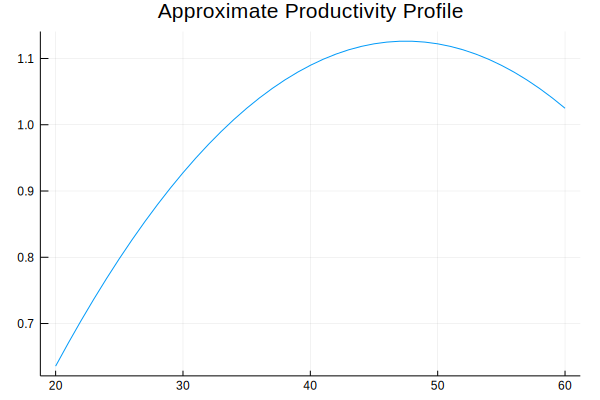

In [3]:
Eff(x) = (-0.0006485)*x^2 + (0.06161)*x + (-0.3371)

_ybar  = [ Eff(j) for j in 20:T+20 ]

plot(20:T+20, _ybar, legend=false, title="Approximate Productivity Profile")

## Preliminaries

In [4]:
# Initial mass distribution:
mass = ones(T+Tr)
for i in 2:length(mass)
    mass[i] = mass[i-1]*_Sprob[i-1]
end

In [5]:
# Mean effective labor supply :
_ybar = _ybar/mean(_ybar)
;

In [6]:
# Initialize the dicrete stochastic process:
Ny = 9

function tauchen(z_l, n, rho, sigma)
    #z = linspace(z_l, z_u, n)
    z = zeros(n)
    z[1] = z_l
    step = -2*z_l/(n-1)
    z[2:end] = [z_l + j*step for j in 2:n]
    #step = (z_u-z_l)/n
    P = zeros(n, n)
    for i in 1:n
        P[i,1] = pnorm((z[1]-rho*z[i])/sigma+step/(2*sigma))
        for j in 2:n-1
            P[i,j] = pnorm((z[j]-rho*z[i])/sigma+step/(2*sigma))-pnorm((z[j]-rho*z[i])/sigma-step/(2*sigma))
        end
        P[i,n] = 1-sum(P[i,:])
    end
    return collect(z), P.*(P .> 10.0^-6)
end

sy = _sigmay1
P = tauchen(-2*sy, Ny, _rho, _sigma)[2]

Ygrid = linspace(-2*sqrt(_sigma/(1-_rho^2)), 4*sqrt(_sigma/(1-_rho^2)), Ny)
;

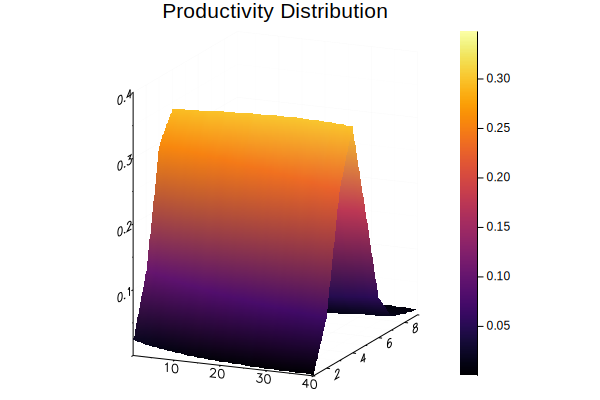

In [7]:
# Initial distribution over productivity:
muy = zeros(T, Ny)
w = Ygrid[2]-Ygrid[1]
muy[1,1] = pnorm((Ygrid[1]+w/2)/sqrt(_sigmay1))
muy[1,Ny] = 1-pnorm((Ygrid[end]-w/2)/sqrt(_sigmay1))
muy[1,2:end-1] = [pnorm((Ygrid[j]+w/2)/sqrt(_sigmay1))-pnorm((Ygrid[j]-w/2)/sqrt(_sigmay1)) for j in 2:Ny-1]
for i in 2:T
    muy[i,:] = muy[i-1,:]'*P.*_Sprob[i]
end

plot(1:T, 1:Ny, muy', linetype=:surface, title="Productivity Distribution")

## Standard Solution

In [27]:
# Prepare options for solution:

K_min = 0.0
K_max = 50.0
Nk    = 100
Kgrid = linspace(K_min, K_max, Nk)

# Finer grid for forward pass:
Nk_fine    = 120 #2*Nk
Kgrid_fine = linspace(K_min, K_max, Nk_fine)

# Project 'x' on capital grid 'Kgrid':
gridind(x) = (K_min + x/(K_max-K_min)*(Nk-1)) + 1
togrid(x)  = Int(round(gridind(x)))

gridind_fine(x) = (K_min + x/(K_max-K_min)*(Nk_fine-1)) + 1

# Utility:
u(c) = (c^(1-_eta)-1)/(1-_eta)

function Value_r(k, x, ValueFs)
    c = (1+r)*k+b-x
    if c <= 0
        return u(10.0^-6)
    else
        return u(c)+_beta*ValueFs[Int(floor(gridind(x)))] #interpValueF_r(x, ValueFs)
    end
end

function Value_w(k, x, t, j, ef, ValueFs)
    c = (1+r)*k+(1-tau)*w*ef*exp(Ygrid[j])*_hbar-x
    if c <= 0
        return u(10.0^-6)
    elseif t == T
        return u(c)+_beta*ValueFs[Int(floor(gridind(x)))] #interpValueF_r(x, ValueFs)
    else 
        return u(c)+_beta*dot(P[j,:], ValueFs[Int(floor(gridind(x))),:]) #interpValueF_w(x, j, ValueFs)
    end
end

# Initialise value functions & policies:
ValueF_r = zeros(Nk, Tr)
Policy_r = ones(Int, Nk, Tr)
Consum_r = zeros(Nk, Tr)
ValueF_w = zeros(Nk, Ny, T)
Policy_w = ones(Int, Nk, Ny, Tr)
Consum_w = zeros(Nk, Ny, T)

# Initialise finer policies for forward pass:
Policy_w_fine = ones(Int, Nk*2, Ny, T)
Policy_r_fine = ones(Int, Nk*2, Ny, Tr)

# Forward distributions:
Dist_k_w = zeros(Nk_fine, Ny, T)
Dist_k_r = zeros(Nk_fine, Tr)
K_gen    = zeros(T+Tr)

;

In [28]:
### INITIAL GUESSES ###

# Computing 'nbar':
nbar = 0.386

# Initial guess for the interest rate 'r':
r = 0.045

# Initial guess for the income tax 'tau':
tau = 0.2

# Compute 'kbar':
kbar = (_alpha/(r+_delta))^(1/(1-_alpha))*nbar

# Initialize 'w' and 'b':
w = 1 
b = 1

AVG_CPU_SOL_TIME = 0;
AVG_CPU_SIM_TIME = 0;

print("---      Initial Values      ---")
print("--- Discretized Prd. Process ---")
println("---     Solution Settings    ---")
print(" nbar[init] = $(round(10^4*nbar)/10^4)\t\t|")
print(" Y_min      = $(round(10^4*Ygrid[1])/10^4)\t\t|")
println(" K_min      = $K_min")
print(" kbar[init] = $(round(10^4*kbar)/10^4)\t\t|")
print(" Y_max      = $(round(10^4*Ygrid[end])/10^4)\t\t|")
println(" K_max      = $K_max")
print(" r[init]    = $r\t\t|")
print(" N[Ygrid]   = $Ny\t\t|")
println(" N[Kgrid]   = $Nk")
print("--- ---- -------------- ---- ---")
print("--- ---- -------------- ---- ---")
println("--- ---- -------------- ---- ---\n")
println("--- [  Running  ] ---")

### SOLUTION ###

# Maximum number of iterations:
forit = 2
it    = 1

# Update rate:
_pphi = 0.3

# Inital covergence criterion:
crit = 1

tic()

while it < forit && crit > 10.0^-3
    
    tic()
    println(" < it = $(@sprintf("%-3i",it)): ")
    print("      solution time = ")

    # Compute implied values for w, r, band tau:
    w   = (1-_alpha)*kbar^_alpha*nbar^(-_alpha)
    b   = _zeta*(1-tau)*w*nbar*(sum(mass)/sum(mass[1:T]))
    if it > 1
        r   = _alpha*kbar^(_alpha-1)*nbar^(1-_alpha)-_delta
        tau = _zeta*(sum(mass[T+1:T+Tr])/sum(mass))/(w*nbar)
    end
    
    # Initialise value functions & policies:
    ValueF_r = zeros(Nk, Tr)
    Policy_r = ones(Int, Nk, Tr)
    Consum_r = zeros(Nk, Tr)
    
    ValueF_w = zeros(Nk, Ny, T)
    Policy_w = ones(Int, Nk, Ny, T)
    Consum_w = zeros(Nk, Ny, T)
    
    Policy_w_fine = ones(Int, Nk_fine, Ny, T)
    Policy_r_fine = ones(Int, Nk_fine, Ny, Tr)
    
    Dist_k_w = zeros(Nk_fine, Ny, T)
    Dist_k_r = zeros(Nk_fine, Tr)
    K_gen    = zeros(T+Tr)
    
    # [ T+Tr ] - Last period of life:
    Consum_r = (1+r)*Kgrid+b
    ValueF_r[:,end] = u.(Consum_r)
    
    # [ T+Tr-1, ..., T+1 ] - Retirement period:
    for s in Tr-1:-1:1 
        # For every 'k' on 'Kgrid':
        for k in 1:length(Kgrid)
            # Value function at the 'Kgrid' points:
            tmpVF(x) = Value_r(Kgrid[k], x, ValueF_r[:,s+1])
            #_VF = Value_r.(Kgrid[k], Kgrid, ValueF_r[:,s+1])
            _VF = tmpVF.(Kgrid)
            # Find the maximum on 'Kgrid'
            ValueF_r[k, s], Policy_r[k, s] = findmax(_VF)
        end
    end
    
    # [ T, ..., 1 ] - Working period:
    for s in T:-1:1
        # [ y[1], ..., y[Ny] ] - Productivity
        for j in 1:Ny
            # For every 'k' on 'Kgrid':
            for k in 1:length(Kgrid)
                # Transition from 'working' to 'retired':
                _VF = 0
                if s == T
                    _VF = map(x->Value_w(Kgrid[k], x, T, j, _ybar[T], ValueF_r[:,1]), Kgrid)
                # In 'working' period:
                else
                    # Value function at the 'Kgrid' points:
                    _VF = map(x->Value_w(Kgrid[k], x, s, j, _ybar[s], ValueF_w[:,:,s+1]), Kgrid)
                end
                # Find the maximum on 'Kgrid'
                ValueF_w[k, j, s], Policy_w[k, j, s] = findmax(_VF)
            end
        end
    end
        
    AVG_CPU_SOL_TIME += toc()
        
    tic()
    print("      simulation time = ")
    
    # Forward pass:
    
    # [ s = 1 ] - Every agent enters with 0 assets:
    Dist_k_w[1,:,1] = muy[1,:]
    K_gen[1] = dot(Kgrid_fine, squeeze(sum(Dist_k_w[:,:,1], 2),2))
    
    
    #tic()
    
    # [ 2, ..., T-1 ] - Working period:
    for s in 1:T-1
        for j in 1:Ny # Every 'y' on 'Ygrid'...
            for kf in 1:length(Kgrid_fine) # Every'k' on 'Kgrid'...
                k1 = 0
                n1 = 0
                if Kgrid_fine[kf] <= K_min
                    k1 = Kgrid[Policy_w[1,j,s]]
                elseif Kgrid_fine[kf] >= K_max
                    k1 = Kgrid[Policy_w[end,j,s]]
                else
                    n2 = Int(floor(gridind(Kgrid_fine[kf])))
                    n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                    k1 = n1*Kgrid[Policy_w[n2,j,s]]+(1-n1)*Kgrid[Policy_w[n2+1,j,s]]
                end
                if k1 <= K_min
                    Dist_k_w[1, :, s+1] += (P[j,:] .* Dist_k_w[kf,j,s])
                elseif k1 >= K_max
                    Dist_k_w[end, :, s+1] += (P[j,:] .* Dist_k_w[kf,j,s])
                else
                    n3 = Int(floor(gridind_fine(k1)))
                    n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                    Dist_k_w[n3+1, :, s+1] += (n1).*(P[j,:] .* Dist_k_w[kf,j,s])
                    Dist_k_w[n3, :, s+1] += (1-n1).*(P[j,:] .* Dist_k_w[kf,j,s])
                end
            end
        end
        #Dist_k_w[:, :, s+1] *= _Sprob[s+1]/sum(Dist_k_w[:, :, s+1])
        K_gen[s+1] = dot(Kgrid_fine, squeeze(sum(Dist_k_w[:,:,s+1], 2),2))
    end
                    
    #toc()
    #println(" ")
                    
    #tic()

    # T - Transition period:
    for j in 1:Ny # Every 'y' on 'Ygrid'...
        for kf in 1:length(Kgrid_fine) # Every'k' on 'Kgrid'...
            k1 = 0
            n1 = 0
            if Kgrid_fine[kf] <= K_min
                k1 = Kgrid[Policy_w[1,j,T]]
            elseif Kgrid_fine[kf] >= K_max
                k1 = Kgrid[Policy_w[end,j,T]]
            else
                n2 = Int(floor(gridind(Kgrid_fine[kf])))
                n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                k1 = n1*Kgrid[Policy_w[n2,j,T]]+(1-n1)*Kgrid[Policy_w[n2+1,j,T]]
            end
            if k1 <= K_min
                Dist_k_r[1, 1] += Dist_k_w[kf,j,T]
            elseif k1 >= K_max
                Dist_k_r[end, 1] += Dist_k_w[kf,j,T]
            else
                n3 = Int(floor(gridind_fine(k1)))
                n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                Dist_k_r[n3+1, 1] += (n1).*Dist_k_w[kf,j,T]
                Dist_k_r[n3, 1] += (1-n1).*Dist_k_w[kf,j,T]
            end
        end
    end
    #Dist_k_r[:, 1] *= _Sprob[T+1]/sum(Dist_k_r[:, 1])
    K_gen[T+1] = dot(Kgrid_fine, Dist_k_r[:,1])
                                    
    #toc()
    #println(" ")
                                    
    #tic()

     # [ T+1, ..., T+Tr ] - Retirement period:
    for s in 1:Tr-1
        for kf in 1:length(Kgrid_fine) # Every 'k' on 'Kgrid'...
            k1 = 0
            n1 = 0
            if Kgrid_fine[kf] <= K_min
                k1 = Kgrid[Policy_r[1,s]]
            elseif Kgrid_fine[kf] >= K_max
                k1 = Kgrid[Policy_r[end,s]]
            else
                n2 = Int(floor(gridind(Kgrid_fine[kf])))
                n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                k1 = n1*Kgrid[Policy_r[n2,s]]+(1-n1)*Kgrid[Policy_r[n2+1,s]]
            end
            if k1 <= K_min
                Dist_k_r[1, s+1] += Dist_k_r[kf,s]
            elseif k1 >= K_max
                Dist_k_r[end, s+1] += Dist_k_r[kf,s]
            else
                n3 = Int(floor(gridind_fine(k1)))
                n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                Dist_k_r[n3+1, s+1] += (n1).*Dist_k_r[kf,s]
                Dist_k_r[n3, s+1] += (1-n1).*Dist_k_r[kf,s]
            end
        end
        #Dist_k_r[:, s+1] *= _Sprob[T+s+1]/sum(Dist_k_r[:, s+1])
        K_gen[T+s+1] = dot(Kgrid_fine, Dist_k_r[:,s+1])
    end
    
    # Update 'kbar' and proceed to new iteration:
    kbar_new = sum(K_gen)/sum(mass)
    kbar     = (1-_pphi)*kbar+_pphi*kbar_new
                                                        
    AVG_CPU_SIM_TIME += toc()
    
    print("------\n   kbar[updated] = $(round(1000*kbar)/1000), ")
    println("kbar[new] = $(round(1000*kbar_new)/1000) >"); 
                                                        
    crit = abs(kbar-kbar_new)
    it += 1

end
                                                    
AVG_CPU_SOL_TIME /= it;
AVG_CPU_SIM_TIME /= it;

println("--- [   Done    ] ---")
println("\n\nTotal execution time:  ")
toc()

;

---      Initial Values      ------ Discretized Prd. Process ------     Solution Settings    ---
 nbar[init] = 0.386		| Y_min      = -1.5152		| K_min      = 0.0
 kbar[init] = 2.6467		| Y_max      = 3.0305		| K_max      = 50.0
 r[init]    = 0.045		| N[Ygrid]   = 9		| N[Kgrid]   = 100
--- ---- -------------- ---- ------ ---- -------------- ---- ------ ---- -------------- ---- ---

--- [  Running  ] ---
 < it = 1  : 
      solution time = elapsed time: 15.942997381 seconds
      simulation time = elapsed time: 5.516964001 seconds
------
   kbar[updated] = 2.325, kbar[new] = 1.574 >
--- [   Done    ] ---


Total execution time:  
elapsed time: 21.856309323 seconds


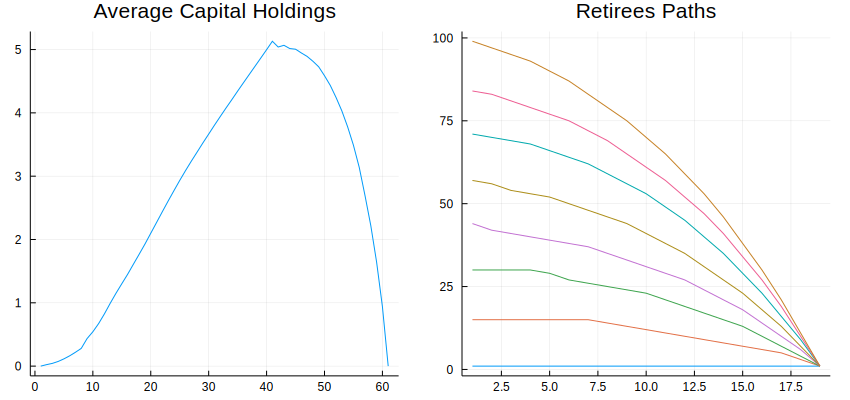

In [10]:
start_s = 2
lit     = 1
Kvec_   = zeros(Tr-start_s+1, 8)

for l in linspace(K_min+0.2, K_max, 8)
    ppath = togrid(l)
    Kvec_[1, lit] = ppath
    for s in start_s:Tr
        ppath = Policy_r[ppath, s]
        Kvec_[s-start_s+1, lit] = ppath
    end
    lit += 1
end

# Average Capital Holdings:
p1 = plot(1:T+Tr+1, vcat(K_gen./mass, 0), title="Average Capital Holdings")
p2 = plot(1:Tr-start_s+1, Kvec_, legend=false, title="Retirees Paths")
plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

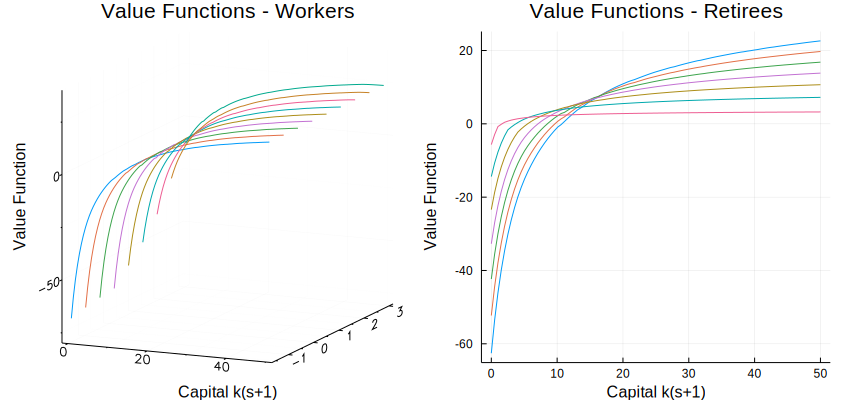

In [11]:
s = T

p1 = plot()
for j = 1:Ny
    plot!(p1, Kgrid, Ygrid[j]*ones(Kgrid), max.(ValueF_w[:,j,s], -500), leg=false, cbar=false, w=1, grid=true, title="Value Functions - Workers")
end
yaxis!("Value Function")
xaxis!("Capital k(s+1)")

p2 = plot(Kgrid, max.(ValueF_r[:,1:3:end], -500), legend=false, title="Value Functions - Retirees")
yaxis!("Value Function")
xaxis!("Capital k(s+1)")

plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

## GPU Accelerated Solution

In [12]:
using CLArrays, GPUArrays

# Initializing the OpenCL device & context:
cl_device = CLArrays.devices()[1]
CLArrays.init(cl_device)

OpenCL context with:
CL version: OpenCL 1.2 
Device: CL Intel(R) Iris(TM) Graphics 550
            threads: 256
             blocks: (256, 256, 256)
      global_memory: 1610.612736 mb
 free_global_memory: NaN mb
       local_memory: 0.065536 mb


In [23]:
# Initialise value functions & policies on the GPU:
ValueF_r_gpu = zeros(CLArray{Float32}, Nk, Tr)
Policy_r_gpu = ones(CLArray{UInt32}, Nk, Tr)
Consum_r = zeros(Nk, Tr)

ValueF_w_gpu = zeros(CLArray{Float32}, Nk, Ny, T)
Policy_w_gpu = ones(CLArray{UInt32}, Nk, Ny, T)
Consum_w = zeros(Nk, Ny, T)

# Move the necessary elements to the GPU:
Kgrid_gpu  = CLArray(Array{Float32}(Kgrid))
Ygrid_gpu  = CLArray(Array{Float32}(Ygrid))
KYgrid_gpu = zeros(CLArray{UInt32}, Nk, Ny)
P_gpu      = CLArray(Array{Float32}(P))
params_gpu = CLArray(Array{Float32}([T; Tr; Nk; Ny; _beta; _eta; _hbar]))
rates_gpu  = CLArray(Array{Float32}([w; r; b; tau;]))

# Initialise finer policies for forward pass:
Policy_w_fine = ones(Int, Nk*2, Ny, Tr)
Policy_r_fine = ones(Int, Nk*2, Ny, T)

# Forward distributions:
Dist_k_w = zeros(Nk_fine, Ny, T)
Dist_k_r = zeros(Nk_fine, Tr)
K_gen    = zeros(T+Tr)

;

In [29]:
# GPU VF interation algorithms:
function Value_r_gpu(s)
    gpu_call(Kgrid_gpu, (Kgrid_gpu, ValueF_r_gpu, Policy_r_gpu, P_gpu, params_gpu, rates_gpu, UInt32(s), UInt32(Nk))) do state, Kgrid_gpu, ValueF_r_gpu, Policy_r_gpu, P_gpu, params_gpu, rates_gpu, s, Nk   
        # Each kernel executes for a 1D index in 'Kgrid':
        idx = @linearidx Kgrid_gpu 
        # If 's' = Tr then the task is trivial...
        if s == UInt32(params_gpu[2])
            c = (1+rates_gpu[2])*Kgrid_gpu[idx] + rates_gpu[3]
            ValueF_r_gpu[idx, s] = (c^(1-params_gpu[6])-1)/(1-params_gpu[6])
            Policy_r_gpu[idx, s] = UInt32(1)
            #return
        # If 's' = Tr-1, ..., 1 execute the VFI...
        else 
            # For every 'k' choice on 'Kgrid' at time 's+1'...
            v_temp  = Float32(0)
            v_max   = Float32(-Inf)
            ind_max = UInt32(1)
            for j in 1:Nk
                # Compute consumption:
                c = (1+rates_gpu[2])*Kgrid_gpu[idx] + rates_gpu[3] - Kgrid_gpu[j]
                # 'c' > 0 then the local value of the VF is not '-Inf':
                if c > 0
                    v_temp = (c^(1-params_gpu[6])-1)/(1-params_gpu[6]) + params_gpu[5]*ValueF_r_gpu[j,s+1]
                    # Store maximum value and its index...
                    if v_temp > v_max
                        v_max = v_temp
                        ind_max = UInt32(j)
                    end
                end
            end
            # 'v_max' and 'ind_max' identify the VFI results and the policy:
            ValueF_r_gpu[idx, s] = v_max
            Policy_r_gpu[idx, s] = ind_max 
        end
        return
    end
end
    
function Value_w_gpu(s, ef)
    gpu_call(KYgrid_gpu, (KYgrid_gpu, Kgrid_gpu, Ygrid_gpu, ValueF_w_gpu, Policy_w_gpu, ValueF_r_gpu, P_gpu, params_gpu, rates_gpu, UInt32(s), Float32(ef), UInt32(Nk), UInt32(Ny))) do state, KYgrid_gpu, Kgrid_gpu, Ygrid_gpu, ValueF_w_gpu, Policy_w_gpu, ValueF_r_gpu, P_gpu, params_gpu, rates_gpu, s, ef, Nk, Ny 
        # Each kernel executes for a 2D index in 'Kgrid'x'Ygrid'
        idx2  = @cartesianidx KYgrid_gpu
        idx_k = idx2[1]
        idx_y = idx2[2]
        # For every 'k' choice on 'Kgrid' at time 's+1'...
        v_temp  = Float32(0)
        v_max   = Float32(-Inf)
        ind_max = UInt32(1)
        for j in 1:Nk
            c = (1+rates_gpu[2])*Kgrid_gpu[idx_k] + (1-rates_gpu[4])*rates_gpu[1]*exp(Ygrid_gpu[idx_y])*params_gpu[7] - Kgrid_gpu[j]
            ValueF_w_gpu[idx_k, idx_y, s] = Float32(ef)
            if c > 0
                if s == params_gpu[1]
                    v_temp = (c^(1-params_gpu[6])-1)/(1-params_gpu[6]) + params_gpu[5]*ValueF_r_gpu[j,1]  
                else
                    #v_temp = (c^(1-params_gpu[6])-1)/(1-params_gpu[6])
                    p_temp = Float32(0)
                    for l in 1:Ny
                        p_temp = p_temp + params_gpu[5]*P_gpu[idx_y,l]*ValueF_w_gpu[j,l,s+1]
                    end 
                    v_temp = (c^(1-params_gpu[6])-1)/(1-params_gpu[6]) + p_temp
                end
                # Store maximum value and its index...
                if v_temp > v_max
                    v_max = v_temp
                    ind_max = UInt32(j)
                end   
            end
        end 
        ValueF_w_gpu[idx_k, idx_y, s] = v_max
        Policy_w_gpu[idx_k, idx_y, s] = ind_max 
        return
    end
end

Value_w_gpu (generic function with 1 method)

In [ ]:
# Pre-execution of the kernel to check for correct compilation:
@time Value_w_gpu(T, _ybar[T])
@time Value_r_gpu(Tr)

;

In [25]:
### INITIAL GUESSES ###

# Computing 'nbar':
nbar = 0.386 # sum(muy.*exp.(Ygrid').*_ybar)*_hbar/sum(mass[1:T])

# Initial guess for the interest rate 'r':
r = 0.045

# Initial guess for the income tax 'tau':
tau = 0.2

# Compute 'kbar':
kbar = (_alpha/(r+_delta))^(1/(1-_alpha))*nbar

# Initialize 'w' and 'b':
w = 1 
b = 1

AVG_GPU_SOL_TIME = 0;
AVG_GPU_SIM_TIME = 0;

print("---      Initial Values      ---")
print("--- Discretized Prd. Process ---")
println("---     Solution Settings    ---")
print(" nbar[init] = $(round(10^4*nbar)/10^4)\t\t|")
print(" Y_min      = $(round(10^4*Ygrid[1])/10^4)\t\t|")
println(" K_min      = $K_min")
print(" kbar[init] = $(round(10^4*kbar)/10^4)\t\t|")
print(" Y_max      = $(round(10^4*Ygrid[end])/10^4)\t\t|")
println(" K_max      = $K_max")
print(" r[init]    = $r\t\t|")
print(" N[Ygrid]   = $Ny\t\t|")
println(" N[Kgrid]   = $Nk")
print("--- ---- -------------- ---- ---")
print("--- ---- -------------- ---- ---")
println("--- ---- -------------- ---- ---")
println(" #### [ using $(cl_device) ] #### \n")
println("--- [  Running (GPU)  ] ---")

### SOLUTION ###

# Maximum number of iterations:
forit = 2
it    = 1

# Update rate:
_pphi = 0.3

# Inital covergence criterion:
crit = 1

tic()

# Iterating until convergence:
while it < forit && crit > 10.0^-3
    
    tic()
    println(" < it = $(@sprintf("%-3i",it)): ")
    print("      solution time = ")

    # Compute implied values for w, r, band tau:
    w   = (1-_alpha)*kbar^_alpha*nbar^(-_alpha)
    b   = _zeta*(1-tau)*w*nbar*(sum(mass)/sum(mass[1:T]))
    if it > 1
        r   = _alpha*kbar^(_alpha-1)*nbar^(1-_alpha)-_delta
        tau = _zeta*(sum(mass[T+1:T+Tr])/sum(mass))/(w*nbar)
    end
        
    rates_gpu = CLArray(Array{Float32}([w; r; b; tau;]))
    
    # Initialise value functions & policies:
    ValueF_r_gpu = zeros(CLArray{Float32}, Nk, Tr)
    Policy_r_gpu = ones(CLArray{UInt32}, Nk, Tr)
    Consum_r = zeros(Nk, Tr)
    
    ValueF_w_gpu = zeros(CLArray{Float32}, Nk, Ny, T)
    Policy_w_gpu = ones(CLArray{UInt32}, Nk, Ny, T)
    Consum_w = zeros(Nk, Ny, T)
    
    Policy_r_fine = ones(Int, Nk_fine, Ny, Tr)
    Policy_w_fine = ones(Int, Nk_fine, Ny, T)
    
    Dist_k_w = zeros(Nk_fine, Ny, T)
    Dist_k_r = zeros(Nk_fine, Tr)
    K_gen    = zeros(T+Tr)
    
    
    # [ T+Tr, ..., T+1 ] - Retirement period:
    for s in Tr-1:-1:1 
        Value_r_gpu(s)
    end
    
    # [ T, ..., 1 ] - Working period:
    for s in T:-1:1
        Value_w_gpu(s, _ybar[s])
    end
    
    AVG_GPU_SOL_TIME += toc()
    
    tic()
    print("      simulation time = ")
                    
    Policy_r = Array{UInt32}(Policy_r_gpu)
    Policy_w = Array{UInt32}(Policy_w_gpu)
    
    # Forward pass:
    
    # [ s = 1 ] - Every agent enters with 0 assets:
    Dist_k_w[1,:,1] = muy[1,:]
    K_gen[1] = dot(Kgrid_fine, squeeze(sum(Dist_k_w[:,:,1], 2),2))
    
    
    #tic()
    
    # [ 2, ..., T-1 ] - Working period:
    for s in 1:T-1
        for j in 1:Ny # Every 'y' on 'Ygrid'...
            for kf in 1:length(Kgrid_fine) # Every'k' on 'Kgrid'...
                k1 = 0
                n1 = 0
                if Kgrid_fine[kf] <= K_min
                    k1 = Kgrid[Policy_w[1,j,s]]
                elseif Kgrid_fine[kf] >= K_max
                    k1 = Kgrid[Policy_w[end,j,s]]
                else
                    n2 = Int(floor(gridind(Kgrid_fine[kf])))
                    n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                    k1 = n1*Kgrid[Policy_w[n2,j,s]]+(1-n1)*Kgrid[Policy_w[n2+1,j,s]]
                end
                if k1 <= K_min
                    Dist_k_w[1, :, s+1] += (P[j,:] .* Dist_k_w[kf,j,s])
                elseif k1 >= K_max
                    Dist_k_w[end, :, s+1] += (P[j,:] .* Dist_k_w[kf,j,s])
                else
                    n3 = Int(floor(gridind_fine(k1)))
                    n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                    Dist_k_w[n3+1, :, s+1] += (n1).*(P[j,:] .* Dist_k_w[kf,j,s])
                    Dist_k_w[n3, :, s+1] += (1-n1).*(P[j,:] .* Dist_k_w[kf,j,s])
                end
            end
        end
        #Dist_k_w[:, :, s+1] *= _Sprob[s+1]/sum(Dist_k_w[:, :, s+1])
        K_gen[s+1] = dot(Kgrid_fine, squeeze(sum(Dist_k_w[:,:,s+1], 2),2))
    end
                    
    #toc()
    #println(" ")
                    
    #tic()

    # T - Transition period:
    for j in 1:Ny # Every 'y' on 'Ygrid'...
        for kf in 1:length(Kgrid_fine) # Every'k' on 'Kgrid'...
            k1 = 0
            n1 = 0
            if Kgrid_fine[kf] <= K_min
                k1 = Kgrid[Policy_w[1,j,T]]
            elseif Kgrid_fine[kf] >= K_max
                k1 = Kgrid[Policy_w[end,j,T]]
            else
                n2 = Int(floor(gridind(Kgrid_fine[kf])))
                n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                k1 = n1*Kgrid[Policy_w[n2,j,T]]+(1-n1)*Kgrid[Policy_w[n2+1,j,T]]
            end
            if k1 <= K_min
                Dist_k_r[1, 1] += Dist_k_w[kf,j,T]
            elseif k1 >= K_max
                Dist_k_r[end, 1] += Dist_k_w[kf,j,T]
            else
                n3 = Int(floor(gridind_fine(k1)))
                n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                Dist_k_r[n3+1, 1] += (n1).*Dist_k_w[kf,j,T]
                Dist_k_r[n3, 1] += (1-n1).*Dist_k_w[kf,j,T]
            end
        end
    end
    #Dist_k_r[:, 1] *= _Sprob[T+1]/sum(Dist_k_r[:, 1])
    K_gen[T+1] = dot(Kgrid_fine, Dist_k_r[:,1])
                                    
    #toc()
    #println(" ")
                                    
    #tic()

     # [ T+1, ..., T+Tr ] - Retirement period:
    for s in 1:Tr-1
        for kf in 1:length(Kgrid_fine) # Every 'k' on 'Kgrid'...
            k1 = 0
            n1 = 0
            if Kgrid_fine[kf] <= K_min
                k1 = Kgrid[Policy_r[1,s]]
            elseif Kgrid_fine[kf] >= K_max
                k1 = Kgrid[Policy_r[end,s]]
            else
                n2 = Int(floor(gridind(Kgrid_fine[kf])))
                n1 = (Kgrid_fine[kf]-Kgrid[n2])/(Kgrid[2]-Kgrid[1])
                k1 = n1*Kgrid[Policy_r[n2,s]]+(1-n1)*Kgrid[Policy_r[n2+1,s]]
            end
            if k1 <= K_min
                Dist_k_r[1, s+1] += Dist_k_r[kf,s]
            elseif k1 >= K_max
                Dist_k_r[end, s+1] += Dist_k_r[kf,s]
            else
                n3 = Int(floor(gridind_fine(k1)))
                n1 = (k1-Kgrid_fine[n3])/(Kgrid_fine[2]-Kgrid_fine[1])
                Dist_k_r[n3+1, s+1] += (n1).*Dist_k_r[kf,s]
                Dist_k_r[n3, s+1] += (1-n1).*Dist_k_r[kf,s]
            end
        end
        #Dist_k_r[:, s+1] *= _Sprob[T+s+1]/sum(Dist_k_r[:, s+1])
        K_gen[T+s+1] = dot(Kgrid_fine, Dist_k_r[:,s+1])
    end
                                                
    #toc()
    #println(" ")
    
    # Update 'kbar' and proceed to new iteration:
    kbar_new = sum(K_gen)/sum(mass)
    kbar     = (1-_pphi)*kbar+_pphi*kbar_new
    
    AVG_GPU_SIM_TIME += toc()
    
    print("------\n   kbar[updated] = $(round(1000*kbar)/1000), ")
    println("kbar[new] = $(round(1000*kbar_new)/1000) >      "); 
    
    crit = abs(kbar-kbar_new)
    it += 1

end
                                                
AVG_GPU_SOL_TIME /= it;
AVG_GPU_SIM_TIME /= it;

println("--- [   Done (GPU)   ] ---")
println("\n\nTotal execution time:  ")
toc()

;

---      Initial Values      ------ Discretized Prd. Process ------     Solution Settings    ---
 nbar[init] = 0.386		| Y_min      = -1.5152		| K_min      = 0.0
 kbar[init] = 2.6467		| Y_max      = 3.0305		| K_max      = 50.0
 r[init]    = 0.045		| N[Ygrid]   = 9		| N[Kgrid]   = 100
--- ---- -------------- ---- ------ ---- -------------- ---- ------ ---- -------------- ---- ---
 #### [ using OpenCL.Device(Intel(R) Iris(TM) Graphics 550 on Apple @0x0000000001024500) ] #### 

--- [  Running (GPU)  ] ---
 < it = 1  : 
      solution time = elapsed time: 1.528738391 seconds
      simulation time = elapsed time: 6.538579495 seconds
------
   kbar[updated] = 2.871, kbar[new] = 3.394 >      
--- [   Done (GPU)   ] ---


Total execution time:  
elapsed time: 8.518425372 seconds


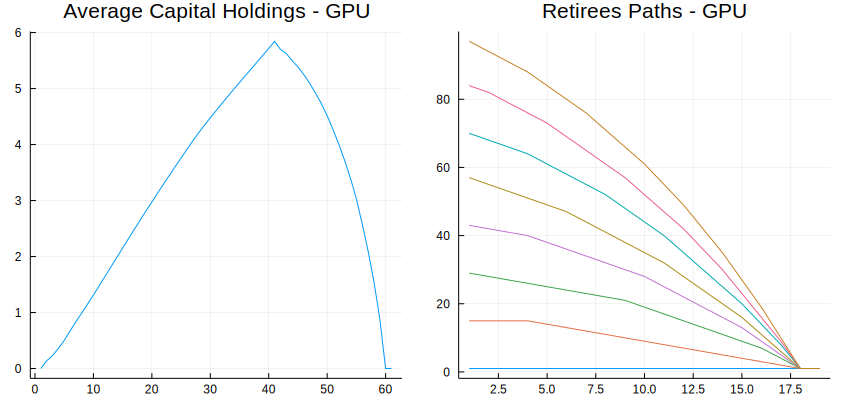

In [18]:
start_s = 2
lit     = 1
Kvec_   = zeros(Tr-start_s+1, 8)

for l in linspace(K_min+0.2, K_max, 8)
    ppath = togrid(l)
    Kvec_[1, lit] = ppath
    for s in start_s:Tr
        ppath = Policy_r[ppath, s]
        Kvec_[s-start_s+1, lit] = ppath
    end
    lit += 1
end

# Average Capital Holdings:
p1 = plot(1:T+Tr+1, vcat(K_gen./mass, 0), title="Average Capital Holdings - GPU")
p2 = plot(1:Tr-start_s+1, Kvec_, legend=false, title="Retirees Paths - GPU")
plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

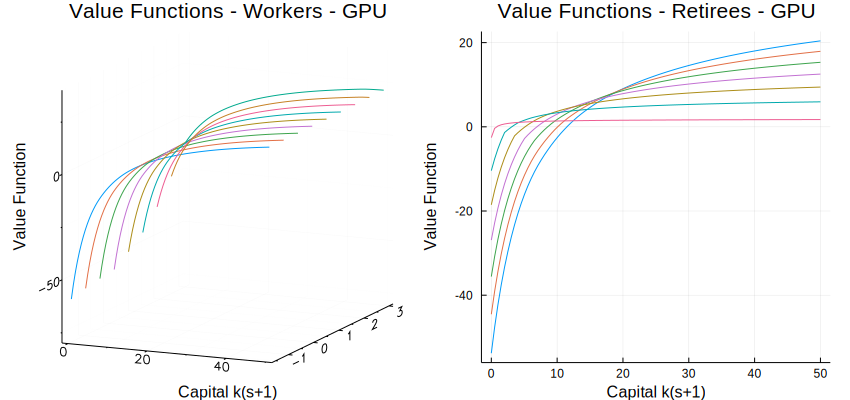

In [19]:
s = T

p1 = plot()
for j = 1:Ny
    plot!(p1, Kgrid, Ygrid[j]*ones(Kgrid), max.(Array{Float64}(ValueF_w_gpu)[:,j,s], -500), leg=false, cbar=false, w=1, grid=true, title="Value Functions - Workers - GPU")
end
yaxis!("Value Function")
xaxis!("Capital k(s+1)")

p2 = plot(Kgrid, max.(Array{Float64}(ValueF_r_gpu)[:,1:3:end], -500), legend=false, title="Value Functions - Retirees - GPU")
yaxis!("Value Function")
xaxis!("Capital k(s+1)")

plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

## Performance

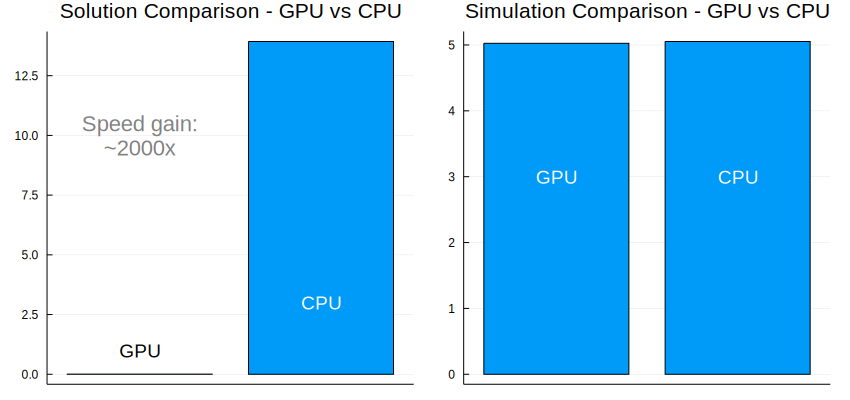

Speed gain for solution: 2131.0662681969675
Total gain: 3.7728651426693802


In [30]:
b1 = bar([1,2], [AVG_GPU_SOL_TIME, AVG_CPU_SOL_TIME], legend=false, title="Solution Comparison - GPU vs CPU", xticks=[])
annotate!([(1, 1, text("GPU",13,:center)),
          (2, 3, text("CPU",13,:white,:center)),
          (1, 10, text("Speed gain:\n ~2000x",15,:left,:grey,:center))])

b2 = bar([1,2], [AVG_GPU_SIM_TIME, AVG_CPU_SIM_TIME], legend=false, title="Simulation Comparison - GPU vs CPU", xticks=[])
annotate!([(1, 3, text("GPU",13,:white,:center)),
          (2, 3, text("CPU",13,:white,:center))])

println("Speed gain for solution: ", AVG_CPU_SOL_TIME / AVG_GPU_SOL_TIME)
println("Total gain: ", (AVG_CPU_SOL_TIME + AVG_CPU_SIM_TIME) / (AVG_GPU_SOL_TIME + AVG_GPU_SIM_TIME))
plot(b1, b2, layout=(1,2), legend=false, size=(850,400))

In [1]:
jj = 20

(max.(Array{Float64}(ValueF_w_gpu)[:,2,jj], -500) -  max.(Array{Float64}(ValueF_w)[:,2,jj], -500))

LoadError: [91mUndefVarError: ValueF_w_gpu not defined[39m

In [26]:
jj = 20

(max.(Array{Float64}(ValueF_r_gpu)[:,jj], -500) -  max.(Array{Float64}(ValueF_r)[:,jj], -500))

100-element Array{Float64,1}:
  2.81406 
  0.389815
 -0.195306
 -0.490698
 -0.676544
 -0.807216
 -0.905528
 -0.982954
 -1.04598 
 -1.09857 
 -1.14332 
 -1.18201 
 -1.21589 
  ⋮       
 -1.70707 
 -1.70872 
 -1.71034 
 -1.71193 
 -1.71349 
 -1.71503 
 -1.71654 
 -1.71803 
 -1.7195  
 -1.72095 
 -1.72237 
 -1.72377 